In [1]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
nlp = spacy.load('en')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('us_companies.csv')
print(df.columns)

Index(['company_name_id', 'company_name', 'url', 'year_founded', 'city',
       'state', 'country', 'zip_code', 'full_time_employees', 'company_type',
       'company_category', 'revenue_source', 'business_model', 'social_impact',
       'description', 'description_short', 'source_count', 'data_types',
       'example_uses', 'data_impacts', 'financial_info', 'last_updated'],
      dtype='object')


#### Data Wrangling

In [496]:
## cleanup empty and misspelled industry codes
df = df[df['company_category'].notnull()]
df.loc[df['company_category']=='Data/Technology,', 'company_category']='Data/Technology'
df.loc[df['company_category']=='Housing/Real Estate,', 'company_category']='Housing/Real Estate'
## removing industry codes that contain only 1 company
df = df[df['company_category']!='Aerospace and Defense']
df = df[df['company_category']!='Media']
print(df.company_category.unique())
print(df.company_category.nunique())

['Data/Technology' 'Finance & Investment' 'Research & Consulting'
 'Governance' 'Environment & Weather' 'Business & Legal Services'
 'Healthcare' 'Lifestyle & Consumer' 'Transportation' 'Insurance'
 'Education' 'Energy' 'Scientific Research' 'Geospatial/Mapping'
 'Housing/Real Estate' 'Food & Agriculture']
16


In [497]:
desc_ind = df[['description', 'company_category']]
print(desc_ind.shape)

(524, 2)


The model works better with numbers than strings. I'll encode the categories as integers.

In [498]:
## encode the categories as integers

desc_ind['category_id']=df['company_category'].factorize()[0]
category_id_df = desc_ind[['company_category', 'category_id']].drop_duplicates().sort_values('category_id')

## create mapping on category_to_id and id_to_category
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'company_category']].values)
desc_ind.head()

,description,company_category,category_id
0,"3 Round Stones produces a platform for publishing data on the Web. 3 Round Stones provides commercial support for the Callimachus Data Platform, used by the Fortune 2000 and US Government Agencies publishing and consuming data. Headquartered in Arlington, Virginia, we're seasoned entrepreneurs who are passionate about solving real world problems through open data and open Web standards.",Data/Technology,0
1,The company mission is to provide finance to small business. We also provide financing to small business with bad credit too on the basis of future credit.,Finance & Investment,1
2,"At 5PSolutions, we wish to make all basic information of different categories easily available to via tablets or phones.",Data/Technology,0
3,"Abt Associates is a mission-driven, international company conducting research and program implementation in the fields of health, social and environmental policy, and international development. The company has multiple offices in the U.S. and program offices in more than 40 countries.",Research & Consulting,2
4,"Accela powers thousands of services and millions of transactions for more than 500 public agencies worldwide, enabling governments to connect with citizens and streamline processes related to land management, asset management, licensing, and public health & safety. Accela addresses a broad range of agency, business and citizen needs, and includes built-in payment, scheduling, compliance and information transparency. Together with our partners, Accela can custom-tailor solutions based on precise agency specifications, or deploy packaged solutions based on best practice templates and pre-defined services in a matter of a few weeks.",Governance,3


#### Text Pre-Processing

In [499]:
## removing html tags
def remove_html_tag(text):
    tag_re = re.compile(r'<[^>]+>')
    text = tag_re.sub('', text)
    text = text.replace("\n","")
    return text

In [500]:
## expanding contractions
import re
from contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [501]:
## removing accented characters
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [502]:
## removing special characters
def remove_special_characters(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    return text

In [503]:
## lemmatizing text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_!='-PRON-' else word.text for word in text])
    return text

In [504]:
## removing stopwords:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
#stopword_list.remove('no')
#stopword_list.remove('not')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [505]:
## Normalize text corpus - altogether
def normalize_corpus(corpus, html_tag_removal=True, accented_char_removal=True, contraction_expansion=True, text_lower_case=True, text_lemmatization=True, 
                    special_char_removal=True, stopword_removal=True):
    normalized_corpus = []
    for doc in corpus:
        if html_tag_removal:
            doc = remove_html_tag(doc)
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        if contraction_expansion:
            doc = expand_contractions(doc)
        if text_lower_case:
            doc = doc.lower()
        if text_lemmatization:
            doc = lemmatize_text(doc)
        if special_char_removal:
            doc = remove_special_characters(doc)
        ## remove extra white spaces
        doc = re.sub(' +', ' ', doc)
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        
        normalized_corpus.append(doc)
    return normalized_corpus

In [506]:
## Normalize company description
description = desc_ind['description']
normalized_description = normalize_corpus(description)
desc_ind['normalized_description'] = normalized_description
desc_ind.head()

,description,company_category,category_id,normalized_description
0,"3 Round Stones produces a platform for publishing data on the Web. 3 Round Stones provides commercial support for the Callimachus Data Platform, used by the Fortune 2000 and US Government Agencies publishing and consuming data. Headquartered in Arlington, Virginia, we're seasoned entrepreneurs who are passionate about solving real world problems through open data and open Web standards.",Data/Technology,0,3 round stone produce platform publish datum web 3 round stone provide commercial support callimachus data platform use fortune 2000 us government agency publish consume datum headquarter arlington virginia season entrepreneur passionate solve real world problem open datum open web standard
1,The company mission is to provide finance to small business. We also provide financing to small business with bad credit too on the basis of future credit.,Finance & Investment,1,company mission provide finance small business also provide financing small business bad credit basis future credit
2,"At 5PSolutions, we wish to make all basic information of different categories easily available to via tablets or phones.",Data/Technology,0,5psolutions wish make basic information different category easily available via tablet phone
3,"Abt Associates is a mission-driven, international company conducting research and program implementation in the fields of health, social and environmental policy, and international development. The company has multiple offices in the U.S. and program offices in more than 40 countries.",Research & Consulting,2,abt associate mission drive international company conduct research program implementation field health social environmental policy international development company multiple office us program office 40 country
4,"Accela powers thousands of services and millions of transactions for more than 500 public agencies worldwide, enabling governments to connect with citizens and streamline processes related to land management, asset management, licensing, and public health & safety. Accela addresses a broad range of agency, business and citizen needs, and includes built-in payment, scheduling, compliance and information transparency. Together with our partners, Accela can custom-tailor solutions based on precise agency specifications, or deploy packaged solutions based on best practice templates and pre-defined services in a matter of a few weeks.",Governance,3,accela power thousand service million transaction 500 public agency worldwide enable government connect citizen streamline process relate land management asset management licensing public health safety accela address broad range agency business citizen need include build payment scheduling compliance information transparency together partner accela custom tailor solution base precise agency specification deploy package solution base good practice template pre define service matter week


#### EDA

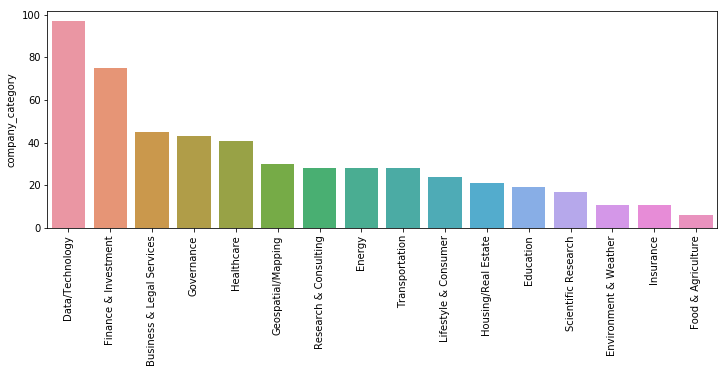

In [507]:
## number of companies in each company_category
fig, ax = plt.subplots(figsize=(12,4))
co_in_cat = desc_ind.company_category.value_counts()
_ = sns.barplot(x=co_in_cat.index, y=co_in_cat, ax=ax)
for i in _.get_xticklabels():
    i.set_rotation(90)

We notice that the data is imbalanced, with most of the companies in the Data/Technology & Finance & Investment group.

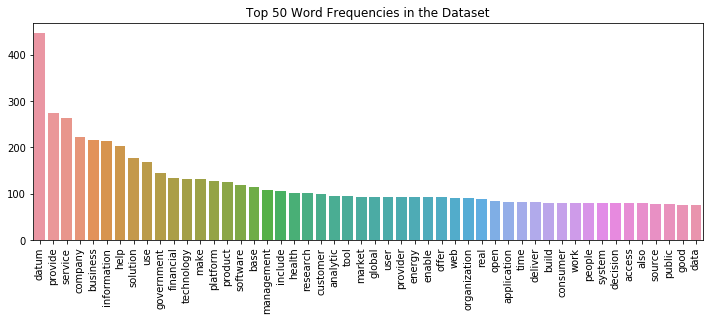

In [508]:
## word counts
all_words = desc_ind.normalized_description.str.split(expand=True).unstack().value_counts()
fig, ax = plt.subplots(figsize=(12,4))
_ = sns.barplot(x=all_words.index[0:50], y=all_words[0:50], ax=ax)
plt.title('Top 50 Word Frequencies in the Dataset')
for i in _.get_xticklabels():
    i.set_rotation(90)

Text(0, 0.5, 'frequency')

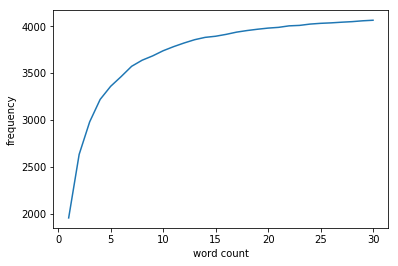

In [509]:
word_count = all_words.value_counts().sort_index()
plt.plot(np.cumsum(word_count).head(30))
plt.xlabel('word count')
plt.ylabel('frequency')

#### Text Exploration

Let's first explore the words in the corpus. I'm interested in both the most frequen unigram & bigram words.

In [510]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, ngram_range=(1,2))
features = tfidf.fit_transform(desc_ind['normalized_description']).toarray()
labels = desc_ind.category_id
features.shape

(524, 3651)

each of the 524 descriptions is represented by 3651 features.

In [511]:
from sklearn.feature_selection import chi2

N = 5
for indcode, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(indcode))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Business & Legal Services':
  . Most correlated unigrams:
. background
. docket
. attorney
. lawyer
. legal
  . Most correlated bigrams:
. business large
. service solution
. resource help
. background check
. individual business
# 'Data/Technology':
  . Most correlated unigrams:
. datum
. extract
. explore
. enterprise
. demographic
  . Most correlated bigrams:
. enterprise software
. base application
. enterprise datum
. complex datum
. business intelligence
# 'Education':
  . Most correlated unigrams:
. education
. teacher
. aid
. college
. student
  . Most correlated bigrams:
. help parent
. help student
. school teacher
. financial aid
. student college
# 'Energy':
  . Most correlated unigrams:
. grid
. utility
. electricity
. solar
. energy
  . Most correlated bigrams:
. energy service
. energy company
. energy efficiency
. energy datum
. energy management
# 'Environment & Weather':
  . Most correlated unigrams:
. newspaper
. carbon
. detection
. forecast
. weather
  . Most co

#### Baseline Model

First try Naive Bayes as the baseline model. Before I start building the model. 

In [512]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [513]:
X = desc_ind['normalized_description']
y = desc_ind['company_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [514]:
#cv = CountVectorizer()
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,5))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
#X_train_cv = cv.fit_transform(X_train)
#X_test_cv= cv.transform(X_test)

In [515]:
## balance the training set

from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=4, random_state=12)
X_sm, y_sm = sm.fit_sample(X_train_tfidf, y_train)
#X_sm, y_sm = sm.fit_sample(X_train_cv, y_train)

#Count the number of occurences in the y_train sets to ensure that the oversampling worked 
from collections import Counter
class_check_woSMOTE = Counter(y_train)
class_check_words = Counter(y_sm)
print('class_check_woSMOTE: ', class_check_woSMOTE)
print('class_check_words: ', class_check_words)

class_check_woSMOTE:  Counter({'Data/Technology': 66, 'Finance & Investment': 52, 'Governance': 29, 'Healthcare': 25, 'Business & Legal Services': 25, 'Energy': 21, 'Transportation': 20, 'Research & Consulting': 19, 'Housing/Real Estate': 17, 'Geospatial/Mapping': 16, 'Lifestyle & Consumer': 16, 'Education': 14, 'Scientific Research': 12, 'Environment & Weather': 8, 'Insurance': 6, 'Food & Agriculture': 5})
class_check_words:  Counter({'Finance & Investment': 66, 'Geospatial/Mapping': 66, 'Environment & Weather': 66, 'Housing/Real Estate': 66, 'Transportation': 66, 'Education': 66, 'Food & Agriculture': 66, 'Scientific Research': 66, 'Healthcare': 66, 'Insurance': 66, 'Governance': 66, 'Energy': 66, 'Data/Technology': 66, 'Business & Legal Services': 66, 'Research & Consulting': 66, 'Lifestyle & Consumer': 66})


In [516]:
clf = MultinomialNB().fit(X_sm, y_sm)

In [517]:
## a little test
print(desc_ind['normalized_description'][160])
print("")
print(desc_ind['normalized_description'][50])
print("")
print(desc_ind['normalized_description'][105])

exversion aim improve accessibility usability datum believe future comparatively small well assemble thoroughly document data set exversion allow search 140000 dataset consume one api upload datum collaborate publish share version control community

blackrock offer mutual fund closed end fund manage account alternative investment individual institution financial professional mission create good financial future client

high medical bill lead personal bankruptcy usa primary lack price quality transparency medical industry two provider maryland charge significantly different price procedure quality care patient typically know cost procedure receive billcomparedcare found 2013 goal provide patient ability compare cost care among provider within area user may upload input medical bill information anonymously without phi personally identifiable information comparedcare medical bill repository patient actively search cost medical procedure within area comparison well read physician review su

In [518]:
print(desc_ind['company_category'][160])
print(desc_ind['company_category'][50])
print(desc_ind['company_category'][105])

Data/Technology
Finance & Investment
Healthcare


In [519]:
print(clf.predict(tfidf.transform(["exversion aim improve accessibility usability datum believe future comparatively small well assemble thoroughly document data set exversion allow search 140000 dataset consume one api upload datum collaborate publish share version control community"])))
print(clf.predict(tfidf.transform(["blackrock offer mutual fund closed end fund manage account alternative investment individual institution financial professional mission create good financial future client"])))
print(clf.predict(tfidf.transform(["high medical bill lead personal bankruptcy usa primary lack price quality transparency medical industry two provider maryland charge significantly different price procedure quality care patient typically know cost procedure receive bill comparedcare found 2013 goal provide patient ability compare cost care among provider within area user may upload input medical bill information anonymously without phi personally identifiable information comparedcare medical bill repository patient actively search cost medical procedure within area comparison well read physician review submit patient one stop shop medical pricing patient"])))

['Data/Technology']
['Finance & Investment']
['Healthcare']


In [520]:
## not too bad

In [521]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_predict_train = clf.predict(X_train_tfidf)
y_predict = clf.predict(X_test_tfidf)
print('Accuracy on training set: ', metrics.accuracy_score(y_train, y_predict_train))
print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_predict))

Accuracy on training set:  0.9287749287749287
Accuracy on test set:  0.5549132947976878


173


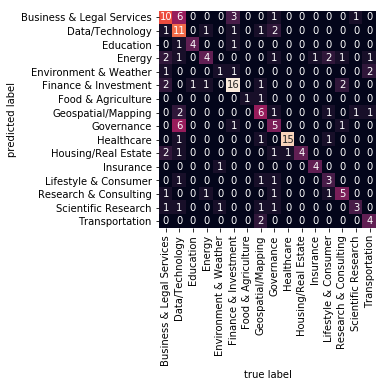

In [522]:
mat = confusion_matrix(y_test, y_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label')
print(len(y_test))

#### Model Selection

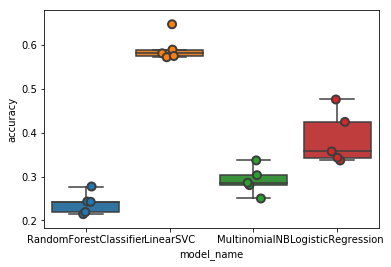

In [523]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
cv = 5
cv_df = pd.DataFrame(index=range(cv * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=cv)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [524]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.592259
LogisticRegression        0.387188
MultinomialNB             0.291150
RandomForestClassifier    0.239195
Name: accuracy, dtype: float64

In [525]:
##Best model

In [526]:
X = desc_ind['normalized_description']
y = desc_ind['category_id']
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, desc_ind.index, test_size=0.33, random_state=0)

In [527]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, max_df=0.3, ngram_range=(1,3))
X_train_tv = tfidf.fit_transform(X_train)
X_test_tv = tfidf.transform(X_test)

In [528]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=4, random_state=1)
X_sm, y_sm = sm.fit_sample(X_train_tv, y_train)

#Count the number of occurences in the y_train sets to ensure that the oversampling worked 
from collections import Counter
class_check_woSMOTE = Counter(y_train)
class_check_words = Counter(y_sm)
print('class_check_woSMOTE: ', class_check_woSMOTE)
print('class_check_words: ', class_check_words)

class_check_woSMOTE:  Counter({0: 66, 1: 52, 3: 29, 5: 25, 6: 25, 11: 21, 8: 20, 2: 19, 14: 17, 7: 16, 13: 16, 10: 14, 12: 12, 4: 8, 9: 6, 15: 5})
class_check_words:  Counter({0: 66, 1: 66, 2: 66, 3: 66, 4: 66, 5: 66, 6: 66, 7: 66, 8: 66, 9: 66, 10: 66, 11: 66, 12: 66, 13: 66, 14: 66, 15: 66})


In [530]:
model = LinearSVC()

model.fit(X_sm, y_sm)
y_pred = model.predict(X_test_tv)

mat = confusion_matrix(y_test, y_pred)

Accuracy on training set :  1.0
Accuracy on test set:  0.6184971098265896


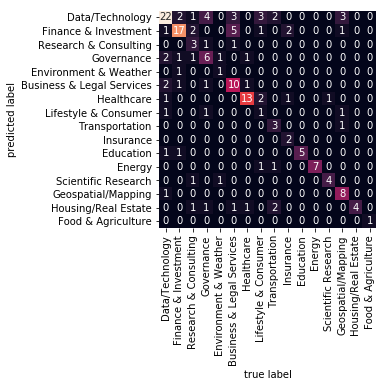

In [531]:
categories = [id_to_category[x] for x in model.classes_]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label')

y_predict_train = model.predict(X_sm)
y_predict = model.predict(X_test_tv)
print('Accuracy on training set : ', metrics.accuracy_score(y_sm, y_predict_train))
print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_pred))

In [532]:
from sklearn.metrics import classification_report
#target_names = ['rotten', 'fresh']
print(classification_report(y_test, y_pred, target_names=list(id_to_category.values())))

                           precision    recall  f1-score   support

          Data/Technology       0.55      0.71      0.62        31
     Finance & Investment       0.59      0.74      0.65        23
    Research & Consulting       0.60      0.33      0.43         9
               Governance       0.50      0.43      0.46        14
    Environment & Weather       0.50      0.33      0.40         3
Business & Legal Services       0.67      0.50      0.57        20
               Healthcare       0.72      0.81      0.76        16
     Lifestyle & Consumer       0.25      0.12      0.17         8
           Transportation       0.75      0.38      0.50         8
                Insurance       1.00      0.40      0.57         5
                Education       0.71      1.00      0.83         5
                   Energy       0.78      1.00      0.88         7
      Scientific Research       0.67      0.80      0.73         5
       Geospatial/Mapping       0.89      0.57      0.70     

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. But many other segments are predicted as Data/Technology. 

In [ ]:
## Find out the misclassifications

In [533]:
from IPython.display import display
pd.set_option('display.max_colwidth', -1)

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and mat[actual, predicted] >= 3:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], mat[actual, predicted]))
            display(desc_ind.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['company_category', 'description']])
            print('')

'Governance' predicted as 'Data/Technology' : 4 examples.


,company_category,description
206,Governance,"We believe a strong nonprofit information infrastructure enables a social sector strong enough to tackle the great challenges of our time. GuideStar provides the key scaffolding - data, information, and knowledge - to enable effective philanthropy: better giving decisions, more effective programs, and measurable impact. We do that by gathering and disseminating information about every single IRS-registered nonprofit organization. We provide as much information as we can about each nonprofit's mission, legitimacy, impact, reputation, finances, programs, transparency, governance, and so much more. We do that so people can make the best decisions possible based on high-quality, comprehensive information."
424,Governance,"SmartProcure is a provider of a government purchase history database. Our SaaS provides instant access to every field within any purchase order in our database of 60 million purchase orders at the local, state, and federal level. Government agencies use our system to find the best value for a product, connect to other government agencies, and conduct their own spend analytics. This is offered to government agencies at no cost. Government contractors can use the system (for an annual fee) to locate potential government clients and conduct market research."
440,Governance,"SpotCrime is a crime mapping website in the US with over half a million subscribers to our alerts. We're a public-facing crime map and alert service that is also an advocate for open, equal, and fair access to public crime data."
319,Governance,"nGAP develops and markets acquisition solutions for government and other large organizations. Their experience with government contracting requirements provides the insight needed to create the financial and operational control large organizations expect. Their solutions conform to the strict regulations that their customers are required to follow. In addition, they incorporate forms libraries so that their solutions produce outputs in formats that each agency requires and can use within their own legacy systems.\n\nnGAP developers are also experienced in integrating solutions with legacy and financial systems, thereby providing increased value and assisting customers with accomplishing their core missions. Sitting on top of our contracting and order processing functions is a comprehensive reporting capability that can house data from a multitude of systems and agencies. Using forensic and reporting tools, nGAP's customers can implement oversight objectives across and within all organizational elements."



'Business & Legal Services' predicted as 'Data/Technology' : 3 examples.


,company_category,description
133,Business & Legal Services,"D&B is a leading source of commercial information and insight on businesses, enabling companies to Decide with Confidence for 172 years. D&B's global commercial database contains more than 225 million business records. The database is enhanced by D&B's proprietary DUNSRight Quality Process, which provides our customers with quality business information to make critical business decisions.\n\nD&B provides solution sets that meet a diverse set of customer needs globally. Customers use D&B Risk Management Solutions to mitigate credit and supplier risk, increase cash flow and drive increased profitability; D&B Sales & Marketing Solutions to increase revenue from new and existing customers; and D&B Internet Solutions to convert prospects into clients faster by enabling business professionals to research companies, executives and industries."
344,Business & Legal Services,"Oversight Systems, Inc. is a privately-held, Atlanta-based software company whose continuous transaction monitoring solutions help Fortune 500 companies in a variety of industries solve problems related to governance, risk and compliance. Oversight’s mission is to transform operational analysis. \n\n<p>Oversight Systems works with consulting firms and business-process experts to design new Insights On Demand. Companies share with us current processes for analyzing data and generating conclusions, and we translate those processes to our Operational Analysis Platform for the automated creation of Insights On Demand.</p>"
474,Business & Legal Services,"TransUnion is a global provider of credit and information management. The company leverages its understanding of consumer information, advanced analytic capabilities, sophisticated technologies and diverse expertise to develop innovative and reliable solutions to meet the changing needs of customers and consumers."



'Lifestyle & Consumer' predicted as 'Data/Technology' : 3 examples.


,company_category,description
398,Lifestyle & Consumer,"RedLaser is a barcode-scanning application for comparison shopping and finding product information using a mobile device. The state-of-the-art barcode scanning technology was created specifically to deal with non-autofocus cameras, and continues to evolve with innovative mobile visual capabilities. The RedLaser application has been downloaded over 2 million times. RedLaser is an eBay company."
109,Lifestyle & Consumer,"CONNECT-DOT are providers of data driven strategies and services, which deliver long term commercial and social benefits, based upon our clients key business requirements. The strategies evolved should be economical, efficient, durable and flexible and empower the organizations and governments to respond rapidly to both market and customer needs."
189,Lifestyle & Consumer,"Geoscape helps clients achieve growth by tapping into America's fast growing Hispanic and multicultural markets. We provide consumer intelligence via strategic business consulting, database-driven analytics and automated systems to help our clients create competitive advantages for business development, marketing and distribution."



'Geospatial/Mapping' predicted as 'Data/Technology' : 3 examples.


,company_category,description
279,Geospatial/Mapping,"Loqate can power your applications with a combination of address capture, verification, and geocoding – all for 240+ countries."
154,Geospatial/Mapping,"Esri inspires and enables people to positively impact the future through a deeper, geographic understanding of the changing world around them. At Esri, we believe that geography is at the heart of a more resilient and sustainable future. Governments, industry leaders, academics, and nongovernmental organizations (NGOs) trust us to connect them with the analytic knowledge they need to make these critical decisions that shape the planet."
313,Geospatial/Mapping,"Navico's vision is to lead marine electronics with outstanding solutions for performance, safety and enjoyment on the water, through a compelling 'house of brands' approach."



'Business & Legal Services' predicted as 'Finance & Investment' : 5 examples.


,company_category,description
138,Business & Legal Services,"Ecodesk is a global supply chain sustainability service provider. At its core is an open cloud-based sustainability platform enabling businesses and organisations to hold their key non-financial metrics in a central location and providing the tool set for detailed analytics of the environmental and social impacts of the supply chain. These analytics enable the benchmarking of suppliers both internal and external to the supply chain and which can greatly reduce inherent risk, identify opportunities and drive efficiency changes."
300,Business & Legal Services,"MicroBilt Corporation is a source and provider of decision critical information that responsibly assists businesses in reducing risk and managing their business. MicroBilt provides online access to consumer and commercial credit bureau data with automated decisioning and collection services. With its PRBC Consumer Report with the FICO Expansion Score, MicroBilt is a leading provider of alternative credit data to businesses that want to offer credit and other financial services to the approximately 110 million underserved and underbanked consumers in the United States.\n\n<p>MicroBilt is also a provider of proprietary financial data with its Integra Data which offers industry benchmarks, norms, valuation data, risk management tools, and other private company financial data that help companies get the answers they need when they need them. The company enables businesses to enhance their content offerings by delivering private labeled content or web sites to their established online communities. </p>"
354,Business & Legal Services,PayScale provides compensation data for individuals and business to maximize their value. We link individuals and businesses to our large salary profile database. Use PayScale to discover what you are worth or find out how our cloud compensation software can help you to pay the right way.
61,Business & Legal Services,"Business Monitor provides trusted, independent analysis and forecasts on countries, industries and financial markets."
346,Business & Legal Services,"Owler is a mobile and online resource that helps you follow, track, and research companies. Get real time updates and news (about your company, your competitors, your clients, your investments), hand-curated from multiple sources."


#### Doc2vec

In [461]:
desc_ind.normalized_description.apply(lambda x: len(x.split(' '))).sum()

25074

In [464]:
from tqdm import tqdm
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [466]:
desc_ind.head()

,description,company_category,category_id,normalized_description
0,"3 Round Stones produces a platform for publishing data on the Web. 3 Round Stones provides commercial support for the Callimachus Data Platform, used by the Fortune 2000 and US Government Agencies publishing and consuming data. Headquartered in Arlington, Virginia, we're seasoned entrepreneurs who are passionate about solving real world problems through open data and open Web standards.",Data/Technology,0,3 round stone produce platform publish datum web 3 round stone provide commercial support callimachus data platform use fortune 2000 us government agency publish consume datum headquarter arlington virginia season entrepreneur passionate solve real world problem open datum open web standard
1,The company mission is to provide finance to small business. We also provide financing to small business with bad credit too on the basis of future credit.,Finance & Investment,1,company mission provide finance small business also provide financing small business bad credit basis future credit
2,"At 5PSolutions, we wish to make all basic information of different categories easily available to via tablets or phones.",Data/Technology,0,5psolutions wish make basic information different category easily available via tablet phone
3,"Abt Associates is a mission-driven, international company conducting research and program implementation in the fields of health, social and environmental policy, and international development. The company has multiple offices in the U.S. and program offices in more than 40 countries.",Research & Consulting,2,abt associate mission drive international company conduct research program implementation field health social environmental policy international development company multiple office us program office 40 country
4,"Accela powers thousands of services and millions of transactions for more than 500 public agencies worldwide, enabling governments to connect with citizens and streamline processes related to land management, asset management, licensing, and public health & safety. Accela addresses a broad range of agency, business and citizen needs, and includes built-in payment, scheduling, compliance and information transparency. Together with our partners, Accela can custom-tailor solutions based on precise agency specifications, or deploy packaged solutions based on best practice templates and pre-defined services in a matter of a few weeks.",Governance,3,accela power thousand service million transaction 500 public agency worldwide enable government connect citizen streamline process relate land management asset management licensing public health safety accela address broad range agency business citizen need include build payment scheduling compliance information transparency together partner accela custom tailor solution base precise agency specification deploy package solution base good practice template pre define service matter week


In [469]:
train, test = train_test_split(desc_ind, test_size=0.3, random_state=42)

import nltk
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['normalized_description']), tags=[r.company_category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['normalized_description']), tags=[r.company_category]), axis=1)

In [470]:
train_tagged.values[30]

TaggedDocument(words=['trulia', 'one', 'real', 'estate', 'site', 'give', 'local', 'scoop', 'home', 'sale', 'apartment', 'rent', 'neighborhood', 'insight', 'real', 'estate', 'market', 'trend', 'help', 'figure', 'exactly', 'buy', 'sell', 'rent', 'also', 'find', 'real', 'estate', 'agent', 'view', 'price', 'recently', 'sell', 'home', 'see', 'home', 'value', 'community', 'trulia', 'also', 'allow', 'get', 'advice', 'opinion', 'local', 'real', 'estate', 'agent', 'broker', 'local', 'expert', 'trulia', 'voice', 'online', 'real', 'estate', 'community'], tags=['Housing/Real Estate'])

In [472]:
## instantiate a doc2vec model 
import multiprocessing
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 369284.40it/s]


In [476]:
from sklearn import utils
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 723769.57it/s]


In [479]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [482]:
## Train the Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.3987341772151899
Testing F1 score: 0.4083482934542373


In [483]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<?, ?it/s]


In [484]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 244522.98it/s]


Wall time: 2.77 s


In [485]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.27848101265822783
Testing F1 score: 0.24961255210500813


In [486]:
## Model Pairing
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [491]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [492]:
## Building feature vectors
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [493]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.2974683544303797
Testing F1 score: 0.3056901653351846


In [432]:
## word cloud for top 3 categories
data_tech = desc_ind[desc_ind['industry_group']=='Data/Technology']['normalized_description'].values
biz_fin = desc_ind[desc_ind['industry_group']=='Business & Financial Services']['normalized_description'].values
con = desc_ind[desc_ind['industry_group']=='Consumer Products & Services']['normalized_description'].values
energy = desc_ind[desc_ind['industry_group']=='Energy']['normalized_description'].values

KeyError: 'industry_group'

In [ ]:
from wordcloud import WordCloud, STOPWORDS
topic_list = {"Data/Technology": data_tech, "Business & Financial Services": biz_fin, 
              "Consumer Products & Services": con}

def generate_wordcloud(topic, title):
    wordcloud = WordCloud().generate(" ".join(topic))
    plt.imshow(wordcloud)#, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

for key, value in topic_list.items():
    generate_wordcloud(value, key)

In [ ]:
# We can see that the companies in the Business & Financial Services sector often offer services on investment, credit, research, and financial and capital management. The Data & Technology sector focuses on datum(data), analytics, and web and software application. Business & Legal Services sector provides mostly legal help, risk management, and lawyer services.